<h1 style="text-align: center; font-weight: bold; text-decoration: underline; text-decoration-color: red;">
    Projet SIGMA M2 : TELEA
</h1>


**Auteur :** Martin Axel


**Objectif :** Le but de ce projet est d’exploiter une série temporelle d’images Sentinel-2 pour analyser et caractériser les strates de végétation et les types de sols (notamment les landes) dans une zone d’étude.
 
Cela implique d’implémenter une chaîne de traitement en Python comprenant l’analyse des échantillons obtenus par photo-interprétation, l’extraction d’indices spectraux pertinents, la réalisation de visualisations statistiques, ainsi que la production et l’évaluation d’une carte de strates à l’aide de méthodes de classification supervisée

### **Importation des bibliothèques nécessaire au projet :**

In [15]:
# ---Importation des bibliothèques---

import os
import sys
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.base import clone

# Ajout du dossier de travail au PYTHONPATH
sys.path.append("/home/onyxia/work/")

# Fonctions personnelles
import my_function as my

# Fonctions libsigma
from libsigma import read_and_write as rw
from libsigma import classification as cla
from libsigma import plots 


## **4.2 Analyse des échantillons** 

#### **4.2.1 Nombre d’échantillons** 

##### **Nombre de polygones par classe :**

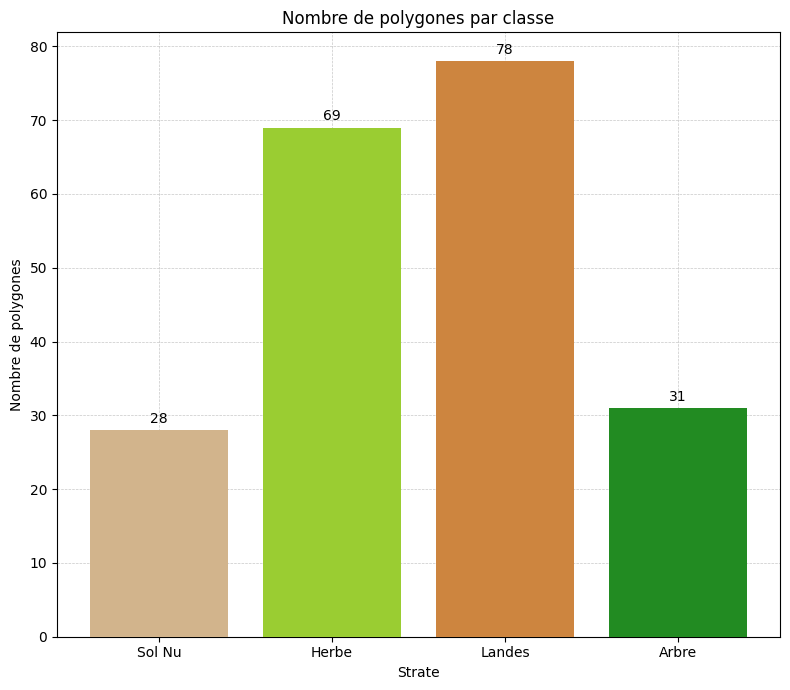

Diagramme généré avec succès : /home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png


In [4]:
# Chemins d’entrée / sortie
ts_path = "/home/onyxia/work/data/projet_eval"
in_vector = os.path.join(ts_path, "PI_strates_pyrenees_32630.shp")
ref_image = os.path.join(ts_path, "pyrenees_23-24_B02.tif")
samples_raster = "/home/onyxia/work/results/samples_raster.tif"

# Dossier pour enregistrer les figures
dir_fig = "/home/onyxia/work/results/figure"
os.makedirs(dir_fig, exist_ok=True)

# Lecture du shapefile d’échantillons
sample_data = gpd.read_file(in_vector)

# Groupement par strate et comptage du nombre de polygones par classe
counts_label = sample_data.groupby("strate").size()

# Styles d’affichage
colors = ["tan", "yellowgreen", "peru", "forestgreen"]
names = {1: "Sol Nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

# Création du graphique : nb de polygones par classe 
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(counts_label.index.astype(int), counts_label.values, color=colors, zorder=3)

# Paramétrage des axes et de l’affichage du graphique
ax.set_xticks(counts_label.index.astype(int))
ax.set_xticklabels([names.get(i, str(i)) for i in counts_label.index.astype(int)])
ax.set_title("Nombre de polygones par classe")
ax.set_xlabel("Strate")
ax.set_ylabel("Nombre de polygones")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=0)

# Ajout des valeurs numériques au-dessus de chaque barre du diagramme
for bar in bars:
    ax.annotate(f"{int(bar.get_height())}",
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points",
                ha="center", va="bottom", zorder=4)

plt.tight_layout() # Ajuste automatiquement la disposition pour éviter les chevauchements
plt.show() # Affiche le graphique à l'écran

# Export de la figure en PNG (300 DPI) avec ajustement automatique des bordures
fig.savefig(os.path.join(dir_fig, "diag_baton_nb_poly_by_class.png"), dpi=300, bbox_inches="tight")

print(  f"Diagramme généré avec succès : " f"{os.path.join(dir_fig, 'diag_baton_nb_poly_by_class.png')}")

### Répartition des polygones d’apprentissage par strate

Ce graphique montre la distribution des polygones utilisés pour l’apprentissage, regroupés par classe de strate.

* **Lecture du résultat :** Les classes *Herbe* et *Landes* sont les plus représentées en nombre de polygones, tandis que *Sol nu* et *Arbre* disposent de moins d’échantillons.
* **Interprétation :** La base d’apprentissage présente donc un léger déséquilibre entre classes, ce qui peut influencer l’entraînement du modèle (classes majoritaires mieux apprises que les classes minoritaires).

**Diagramme de flux :**
![Flux de traitement pour générer l'histogramme de répartition des polygones par classe](/home/onyxia/work/projet_telea_MARTIN_AXEL/img/Diagramme_nb_polygone_classe.png)

##### **Nombre de pixel par classe :**

gdal_rasterize -at -a strate -tr 10.0 10.0 -te 684590.0 4744830.0 705620.0 4761380.0 -a_nodata 0 -ot Int32 -of GTiff "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp" "/home/onyxia/work/results/samples_raster.tif"
0...10...20...30...40...50...60...70...80...90...100 - done.


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


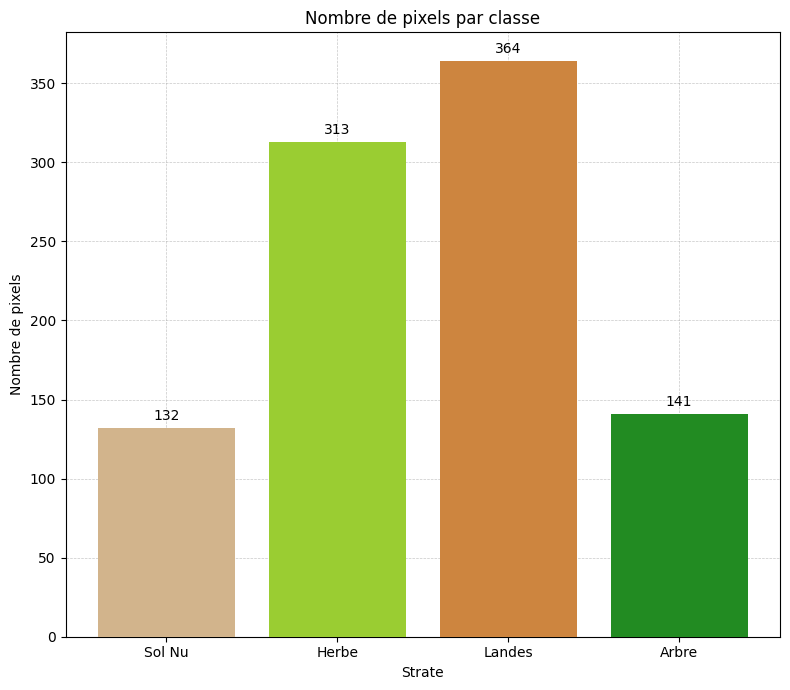

Diagramme généré avec succès : /home/onyxia/work/results/figure/diag_baton_nb_pix_by_class.png


In [5]:
# Rasterisation du shapefile (champ "strate") sur la grille de ref_image via la fonction rasterisation
my.rasterisation(in_vector, ref_image, samples_raster, "strate", dtype="Int32")

# Chargement des pixels de samples_raster en tableau NumPy
arr3d = rw.load_img_as_array(samples_raster, verbose=False)
arr = arr3d[:, :, 0]

# Comptage des pixels par classe 
vals = arr[arr != 0]
values, counts = np.unique(vals, return_counts=True)

# Création du graphique : nb de pixels par classe 
fig, ax = plt.subplots(figsize=(8, 7))
bars = ax.bar(values.astype(int), counts, color=colors[:len(values)], zorder=3)

ax.set_xticks(values.astype(int))
ax.set_xticklabels([names.get(v, str(v)) for v in values.astype(int)])
ax.set_title("Nombre de pixels par classe")
ax.set_xlabel("Strate")
ax.set_ylabel("Nombre de pixels")
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7, zorder=0)

for bar in bars:
    ax.annotate(f"{int(bar.get_height())}",
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, max(counts) * 0.01), textcoords="offset points",
                ha="center", va="bottom", zorder=4)

plt.tight_layout() 
plt.show() 

fig.savefig(os.path.join(dir_fig, "diag_baton_nb_pix_by_class.png"), dpi=300, bbox_inches="tight")

print( f"Diagramme généré avec succès : " f"{os.path.join(dir_fig, 'diag_baton_nb_pix_by_class.png')}")

### Répartition des pixels après rasterisation

Ce graphique présente la distribution des pixels issus de la rasterisation des polygones.

* **Principe :** Le comptage est réalisé à partir du raster de strates obtenu après rasterisation.
* **Paramètre clé :** Le paramètre `all_touched=True` est utilisée lors de la rasterisation. Tous les pixels touchant un polygone, y compris ceux situés en bordure, sont affectés à la classe correspondante. Ce choix permet de mieux représenter l’emprise réelle des polygones, mais augmente le nombre de pixels comptabilisés.
* **Lecture du résultat :** La classe *Landes* domine en nombre de pixels, suivie par *Herbe*. Les classes *Sol nu* et *Arbre* sont moins représentées.
* **Interprétation :** La répartition en pixels ne reflète pas strictement celle des polygones, en raison des différences de surface entre les objets et de l’utilisation de `all_touched=True`, qui accentue l’influence des contours.

**Diagramme de flux :**
![Flux de traitement pour générer l'histogramme de répartition des pixels par classe](/home/onyxia/work/projet_telea_MARTIN_AXEL/img/Diagramme_nb_pixel_classe.png)

#### **4.2.2 Phénologie des strates, mise en évidence des landes**

#### **Création du raster d'ARI**

### Calcul de l’indice ARI (Anthocyanin Reflectance Index)

Les landes que l’on cherche à caractériser appartiennent majoritairement à la famille des Éricacées. Ces formations végétales se distinguent notamment par une forte présence d’anthocyanes, des pigments végétaux jouant un rôle comparable à celui de la chlorophylle. La concentration en anthocyanes est particulièrement marquée en période automnale, ce qui confère aux landes une signature spectrale spécifique.

Afin de caractériser cette signature, le **Normalized Anthocyanin Reflectance Index (ARI)** est calculé à partir des bandes spectrales correspondantes. Cet indice permet de mettre en évidence la présence relative d’anthocyanes dans la végétation et constitue un indicateur pertinent pour l’étude des strates végétales riches en ces pigments.

La formule de l’indice ARI est définie comme suit :

$$
ARI = \dfrac{\dfrac{1}{B_{03}} - \dfrac{1}{B_{05}}}{\dfrac{1}{B_{03}} + \dfrac{1}{B_{05}}}
$$


où :
- \(B03\) correspond à la bande verte,
- \(B05\) correspond à la bande du proche infrarouge.


In [6]:

# ---Calcul de l’indice ARI (série temporelle) à partir des bandes B03 et B05---


# Correspondance entre types numpy et types GDAL
data_type_match = {
    'uint8': gdal.GDT_Byte,
    'uint16': gdal.GDT_UInt16,
    'uint32': gdal.GDT_UInt32,
    'int16': gdal.GDT_Int16,
    'int32': gdal.GDT_Int32,
    'float32': gdal.GDT_Float32,
    'float64': gdal.GDT_Float64
}

# Définition des chemins 
dirname = '/home/onyxia/work/data/projet_eval'
out_dirname = '/home/onyxia/work/results'
dir_B3 = os.path.join(dirname, 'pyrenees_23-24_B03.tif')
dir_B5 = os.path.join(dirname, 'pyrenees_23-24_B05.tif')
out_ari_filename = os.path.join(out_dirname, 'ARI_serie_temp.tif')

# Ouverture du raster B03
data_set_B3 = rw.open_image(dir_B3)
# Chargement des pixels B03 en tableau NumPy
img_B3 = rw.load_img_as_array(dir_B3)

data_set_B5 = rw.open_image(dir_B5)
img_B5 = rw.load_img_as_array(dir_B5)

# Conversion en float pour le calcul des indices 
B3 = img_B3[:, :, :].astype('float32')
B5 = img_B5[:, :, :].astype('float32')

# Calcul de l’indice ARI via la fonction compute_ari_timeseries (série temporelle) 
ari = my.compute_ari_timeseries(B3, B5)

# Écriture du raster ARI via la fonction write_image
rw.write_image(
    out_ari_filename,
    ari,
    data_set=data_set_B5,
    gdal_dtype=data_type_match['float32'],
    projection=None
)

# Définition de la valeur NoData 
ds = gdal.Open(out_ari_filename, gdal.GA_Update)
band = ds.GetRasterBand(1)
band.SetNoDataValue(-9999)
band.FlushCache()
ds = None

print(f"Raster ARI généré avec succès : {out_ari_filename}")

ARI stats: min = -0.969209 max = 0.880237 mean = 0.110966586
Raster ARI généré avec succès : /home/onyxia/work/results/ARI_serie_temp.tif


Dans cette étape, les rasters correspondant aux bandes spectrales B03 et B05 sont récupérés à partir des données d’entrée. Ces bandes sont ensuite chargées sous forme de tableaux NumPy afin de pouvoir être manipulées pour le calcul de l’indice.

Les valeurs des bandes sont converties en type flottant (`float32`) afin d’assurer la stabilité numérique des calculs, notamment lors des opérations de division nécessaires au calcul de l’indice ARI. L’indice est alors calculé pixel par pixel pour l’ensemble de la série temporelle à partir des bandes B03 et B05, ce qui permet d’obtenir un raster multi-temporel représentant l’évolution spatiale et temporelle de l’ARI.

Une fois le calcul effectué, le raster de l’indice ARI est exporté vers un fichier géoréférencé en conservant les informations spatiales du raster de référence. Enfin, une valeur NoData est définie afin d’identifier les pixels non valides et de garantir une utilisation correcte du raster lors des analyses ultérieures.


**Diagramme de flux :**
![Flux de traitement pour calculer le Normalized Anthocyanin Reflectance Index (NARI)](/home/onyxia/work/projet_telea_MARTIN_AXEL/img/DIagramme_raster_ARI.png)

#### **Création du graphique de série temporelle moyenne d’ARI de chaque strate**

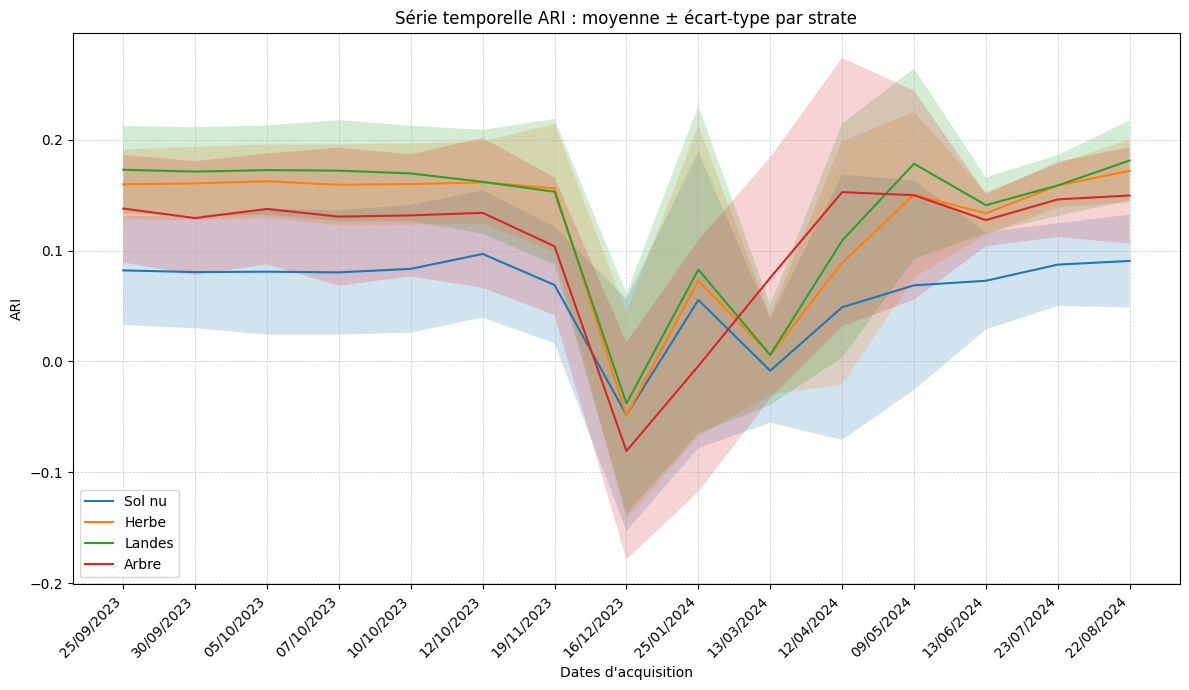

Diagramme de la série temporelle ARI généré avec succès : /home/onyxia/work/results/figure/ARI_series.png


In [7]:
# ---Analyse des séries temporelles de l’indice ARI par strate---


# Définition des dates d’acquisition 
dates = [
    "25/09/2023", "30/09/2023", "05/10/2023", "07/10/2023", "10/10/2023",
    "12/10/2023", "19/11/2023", "16/12/2023", "25/01/2024", "13/03/2024",
    "12/04/2024", "09/05/2024", "13/06/2024", "23/07/2024", "22/08/2024"
]

# Extraction des pixels ARI par strate via la fonction get_samples_from_roi
dict_X, dict_Y, dict_t = cla.get_samples_from_roi(
    out_ari_filename,
    samples_raster,
    output_fmt="by_label"
)

# Dictionnaire de correspondance entre codes et noms des strates
names = {1: "Sol nu", 2: "Herbe", 3: "Landes", 4: "Arbre"}

# Initialisation de la figure 
fig, ax = plt.subplots(figsize=(12, 7))

# Nombre de dates (bandes temporelles)
n_dates = dict_X[list(dict_X.keys())[0]].shape[1]
x = np.arange(n_dates)

# Calcul et tracé des statistiques par strate 
# Pour chaque strate, la moyenne et l’écart-type de l’ARI sont calculés à chaque date afin de représenter la dynamique temporelle.
for lab in sorted(dict_X.keys()):
    X = dict_X[lab]

    # Remplacement des valeurs NoData par NaN pour éviter leur prise en compte
    X = np.where(X == -9999, np.nan, X)

    mean = np.nanmean(X, axis=0)
    std  = np.nanstd(X, axis=0)

    ax.plot(x, mean, label=names.get(lab, f"Strate {lab}"))
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

# Mise en forme du graphique 
ax.set_xlabel("Dates d'acquisition")
ax.set_ylabel("ARI")
ax.set_title("Série temporelle ARI : moyenne ± écart-type par strate")
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.legend()

# Remplacement des indices temporels par les dates réelles
ax.set_xticks(x)
ax.set_xticklabels(dates, rotation=45, ha='right')

# Affichage et sauvegarde de la figure
plt.tight_layout()
plt.show()
fig.savefig(os.path.join(dir_fig, "ARI_series.png"), dpi=300, bbox_inches='tight')

print(f"Diagramme de la série temporelle ARI généré avec succès : {os.path.join(dir_fig, 'ARI_series.png')}")

### Analyse de l’indice ARI par strate

* **Évolution temporelle globale :**  
  L’analyse de la série temporelle de l’ARI met en évidence une évolution cohérente de l’indice pour l’ensemble des strates étudiées. Toutes les classes présentent une chute marquée des valeurs d’ARI en décembre 2023, suivie d’une remontée progressive à partir du printemps 2024. Cette dynamique commune traduit la sensibilité de l’ARI aux conditions saisonnières et à l’activité végétative, ce qui est attendu pour un indice spectral lié à la végétation.

* **Positionnement de la classe *Landes* :**  
  La classe *Landes* se distingue globalement du *Sol nu* par des valeurs d’ARI plus élevées sur l’ensemble de la période étudiée. Elle présente également, selon les dates, des valeurs comparables ou légèrement supérieures à celles de la classe *Arbre*, notamment au printemps et en été 2024. Ces résultats suggèrent que l’ARI permet une discrimination partielle des landes par rapport à certaines strates.

* **Similarité entre *Landes* et *Herbe* :**  
  La distinction entre les classes *Landes* et *Herbe* apparaît plus délicate. Les valeurs moyennes d’ARI de ces deux strates sont très proches sur l’ensemble de la série temporelle, et leurs dynamiques temporelles sont similaires. Le fort chevauchement des intervalles moyenne ± écart-type indique une variabilité intra-classe comparable et des distributions d’ARI largement recouvrantes, rendant la discrimination entre ces deux strates difficile à partir de la moyenne de l’ARI seule.

* **Apport et limites de la moyenne et de l’écart-type :**  
  La moyenne et l’écart-type permettent de résumer le niveau moyen de l’ARI et sa dispersion autour de cette moyenne. Cependant, ces deux indicateurs restent insuffisants pour décrire la forme complète des distributions : ils ne renseignent pas sur l’asymétrie, la présence de valeurs extrêmes, ni sur la position de la médiane. Ainsi, deux strates peuvent présenter des moyennes et des écarts-types proches tout en ayant des distributions différentes. Il apparaît donc pertinent de compléter cette analyse par d’autres statistiques descriptives (médiane, quantiles, écart interquartile), ainsi que par des analyses de distribution ou des tests statistiques comparatifs afin de mieux comparer les strates.



**Diagramme de flux :**
![Flux de traitement pour générer le graphique de série temporelle d'ARI](/home/onyxia/work/projet_telea_MARTIN_AXEL/img/Diagramme_Graphique_Serie_Temp.png)

## **4.3 Production d’une carte de strates à l’échelle du pixel**

### Classification supervisée des strates

Dans cette partie, une approche de classification supervisée est mise en œuvre afin de discriminer les différentes strates à partir des données satellitaires Sentinel-2. Afin de maximiser l’information spectrale disponible pour l’apprentissage du modèle, il a été choisi de fusionner l’ensemble des bandes Sentinel-2 mises à disposition avec l’indice ARI préalablement calculé.

Le choix de cette fusion repose sur un double objectif. D’une part, les bandes spectrales Sentinel-2 permettent de caractériser finement les propriétés radiométriques et structurelles de la surface (visible, proche infrarouge, red-edge et infrarouge à ondes courtes). D’autre part, l’indice ARI apporte une information complémentaire ciblée sur la présence d’anthocyanes, particulièrement pertinente pour la caractérisation des landes, souvent composées d’Éricacées. La combinaison de ces variables permet ainsi de constituer un jeu de variables explicatives riche et complémentaire, susceptible d’améliorer les performances de classification.

Le modèle utilisé pour la classification est un **Random Forest**. Il s’agit d’un algorithme couramment mobilisé en télédétection pour la classification supervisée, notamment car il est robuste face au bruit, capable de gérer un grand nombre de variables explicatives et généralement performant dans des contextes multi-classes. Afin d’optimiser ses hyperparamètres et de limiter les risques de sur-apprentissage, une **recherche par grille (GridSearchCV)** est mise en œuvre, couplée à une validation croisée.


L’évaluation du modèle repose sur une **validation croisée stratifiée avec contrainte de groupes** (`StratifiedGroupKFold`). Cette stratégie permet à la fois de conserver une répartition équilibrée des classes dans les plis et d’éviter toute fuite d’information entre les ensembles d’apprentissage et de test, en imposant qu’un même groupe spatial ne soit jamais présent simultanément dans les deux ensembles. Les performances sont ensuite analysées à l’aide de métriques globales (accuracy) et de métriques par classe (précision, rappel et F1-score), agrégées sur l’ensemble des plis de la validation croisée.


#### **4.3.2 Stratégie de validation (GridSearchCV)** ###

##### **Fusion de toutes les bandes spectrales Sentinel-2 + ARI :**

In [8]:
# ---Construction du stack multi-bandes fusionné (Sentinel-2 + ARI)---


# Liste des bandes spectrales Sentinel-2 utilisées
bands = [
    "B02",
    "B03",
    "B04",
    "B05",
    "B06",
    "B07",
    "B08",
    "B8A",
    "B11",
    "B12"
]

# Construction du stack fusionné via la fonction create_feature_stack 
stack_fused, ds_ref = my.create_feature_stack(
    folder=ts_path,
    prefix="pyrenees_23-24",
    bands=bands,
    ari_path=out_ari_filename
)

# Écriture du raster fusionné 
out_fused = "/home/onyxia/work/results/py_ari_stack.tif"
rw.write_image(
    out_fused,
    stack_fused,
    data_set=ds_ref,
    nb_band=stack_fused.shape[2]
)

print(f"Stack fusionné généré avec {stack_fused.shape[2]} bandes : {out_fused}")

Stack fusionné généré avec 165 bandes : /home/onyxia/work/results/py_ari_stack.tif


##### **Entraînement et optimisation du modèle de classification :**

In [9]:
# ---Extraction des échantillons pour l’apprentissage supervisé---


# Rasterisation du shapefile (champ "id")
samples_raster_id = '/home/onyxia/work/results/samples_raster_id.tif'
my.rasterisation(in_vector, ref_image, samples_raster_id, "id", dtype="Int32")

# Extraction des variables explicatives (X), des classes (Y) et des positions des pixels à partir du stack fusionné
X, Y, t = cla.get_samples_from_roi(out_fused, samples_raster)

# Extraction des identifiants de groupes 
_, groups, _ = cla.get_samples_from_roi(out_fused, samples_raster_id)

# Mise en forme des vecteurs cibles et des groupes
Y = np.asarray(Y).reshape(-1)
groups = np.asarray(groups).reshape(-1)

# ------------------------------------------------------------
# Définition du modèle et de la grille d’hyperparamètres
# ------------------------------------------------------------

# Initialisation du classifieur Random Forest
rf = RF(random_state=0, n_jobs=-1)

# Grille d’hyperparamètres
param_grid = {
    "n_estimators": [150, 300],
    "max_depth": [None, 20],
    "max_features": ["sqrt"],
    "min_samples_leaf": [1, 5],
}


# ---Validation croisée stratifiée avec contrainte de groupes---


# Définition d’une validation croisée stratifiée en 5 plis, avec mélange des données et graine aléatoire fixée pour garantir la reproductibilité des résultats
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=0)

# Recherche des meilleurs hyperparamètres par GridSearch
grid = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

# Entraînement du modèle avec prise en compte des groupes
grid.fit(X, Y, groups=groups)

# Affichage des meilleurs paramètres et de la performance associée
print(grid.best_params_)

# Récupération du meilleur modèle entraîné
best_model = grid.best_estimator_

gdal_rasterize -at -a id -tr 10.0 10.0 -te 684590.0 4744830.0 705620.0 4761380.0 -a_nodata 0 -ot Int32 -of GTiff "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp" "/home/onyxia/work/results/samples_raster_id.tif"
0...10...20...30...40...50...60...70...80...90...100 - done.
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 150}


OA = 0.830 ± 0.084


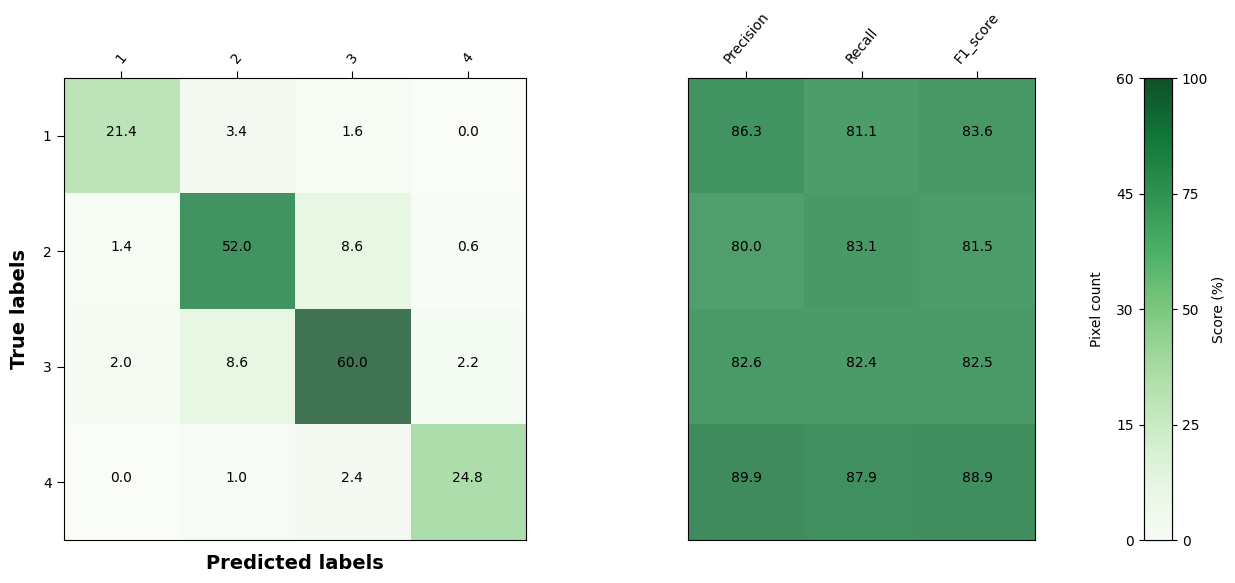

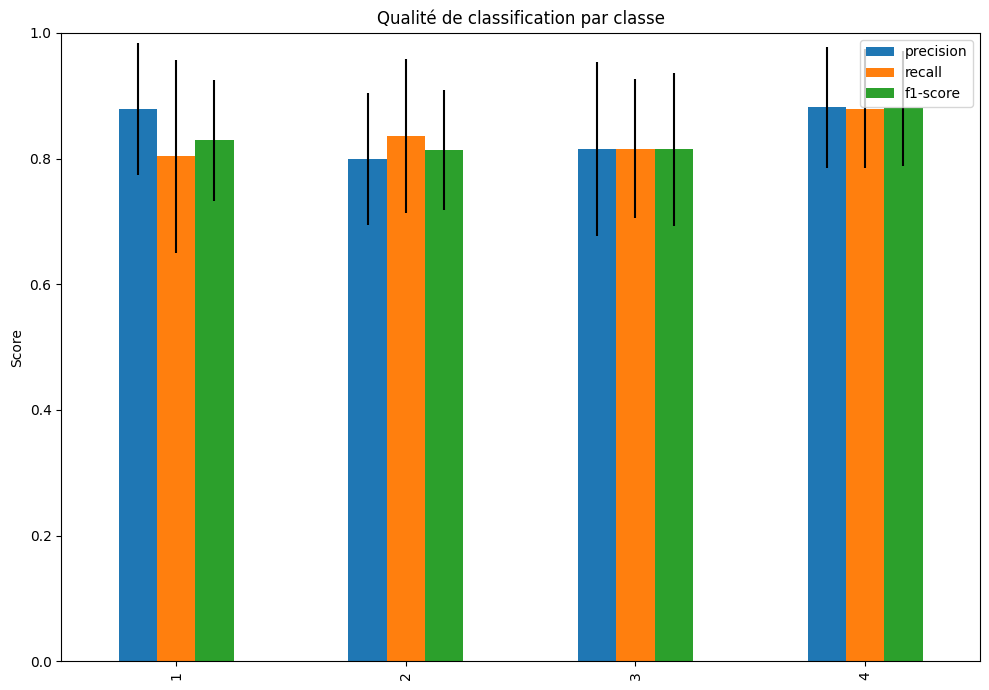

In [ ]:
# ---Évaluation du modèle par validation croisée groupée---


list_cm = []          # matrices de confusion
list_accuracy = []    # accuracies globales
list_report = []      # rapports de classification par classe


# ---Boucle sur les folds de la validation croisée---


for train_idx, test_idx in cv.split(X, Y, groups=groups):

    # Séparation apprentissage / test
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]

    # Clonage du meilleur modèle trouvé par GridSearch
    clf = clone(best_model)
    clf.fit(X_train, Y_train)

    # Prédiction sur le jeu de test
    Y_pred = clf.predict(X_test)

    # Calcul et stockage de la matrice de confusion
    list_cm.append(
        confusion_matrix(Y_test, Y_pred, labels=np.unique(Y))
    )

    # Calcul et stockage de l’accuracy globale
    list_accuracy.append(
        accuracy_score(Y_test, Y_pred)
    )

    # Calcul et stockage des métriques par classe
    rep = classification_report(
        Y_test,
        Y_pred,
        labels=np.unique(Y),
        output_dict=True,
        zero_division=0
    )
    list_report.append(pd.DataFrame(rep).T)


# ---Agrégation des résultats sur l’ensemble des folds---


# Moyenne de la matrice de confusion
array_cm = np.array(list_cm)
mean_cm = array_cm.mean(axis=0)

# Moyenne et écart-type de l’accuracy globale
array_accuracy = np.array(list_accuracy)
mean_accuracy = array_accuracy.mean()
std_accuracy = array_accuracy.std()

# Moyenne et écart-type des métriques par classe
all_reports = pd.concat(list_report, keys=range(len(list_report)))
mean_df_report = all_reports.groupby(level=1).mean()
std_df_report  = all_reports.groupby(level=1).std()

print(f"OA = {mean_accuracy:.3f} ± {std_accuracy:.3f}")


# ---Visualisation des performances---


# Affichage de la matrice de confusion moyenne
plots.plot_cm(mean_cm, labels=list(np.unique(Y)))
plt.show()

# Barplot des métriques par classe (precision / recall / f1-score)
class_labels = [str(l) for l in np.unique(Y)]
mean_cls = mean_df_report.loc[class_labels, ["precision", "recall", "f1-score"]]
std_cls  = std_df_report.loc[class_labels,  ["precision", "recall", "f1-score"]]

ax = mean_cls.plot.bar(yerr=std_cls, figsize=(10, 7), zorder=2)
ax.set_ylim(0, 1)
ax.set_title("Qualité de classification par classe")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()

**Diagramme de flux :**
![Flux de traitement pour générer le graphique de série temporelle d'ARI](/home/onyxia/work/projet_telea_MARTIN_AXEL/img/Diagramme_Pipeline_Classification_Supervisée.png)


#### **4.3.3 Contribution des variables**

n_series temporelles = 11


,feature,importance
0,B03_13/03/2024,0.026719
1,B03_25/09/2023,0.021329
2,B04_13/03/2024,0.020554
3,B04_10/10/2023,0.019393
4,B03_22/08/2024,0.019228
5,B04_30/09/2023,0.018405
6,B03_30/09/2023,0.017816
7,B02_25/09/2023,0.017338
8,ARI_25/09/2023,0.016870
9,B02_13/03/2024,0.016869


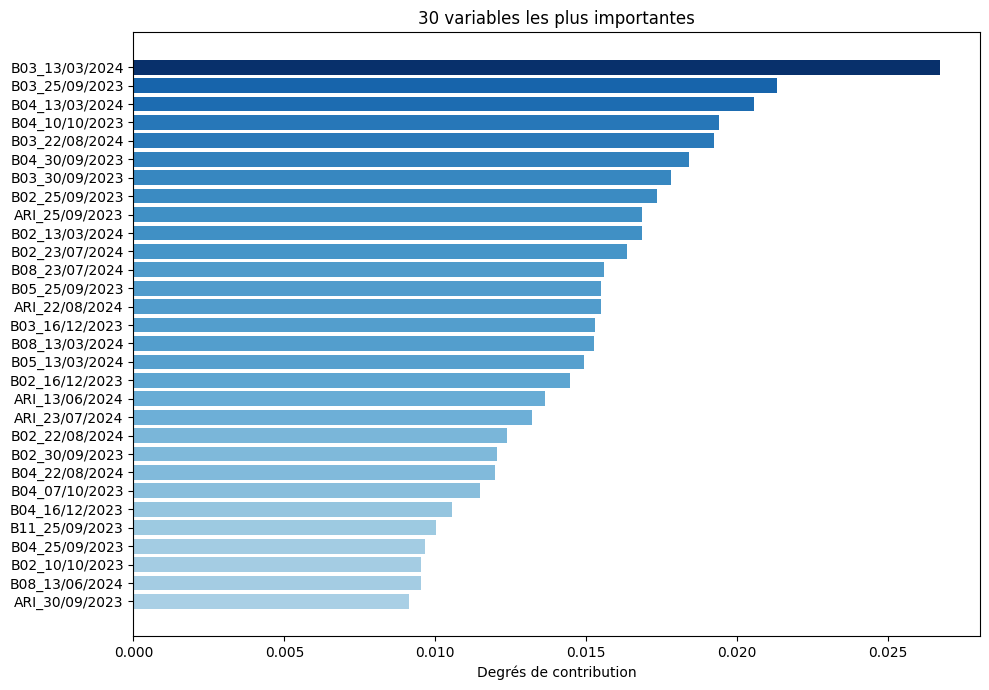

In [ ]:
# ---Analyse de l’importance des variables du modèle Random Forest---

# Récupération des importances calculées par le Random Forest
importances = best_model.feature_importances_

# Nombre total de variables utilisées par le modèle
n_features = importances.shape[0]


# ---Définition des dates de la série temporelle---


# Dates d’acquisition des images Sentinel-2 (ordre chronologique)
n_dates = len(dates)


# ---Reconstruction du nom des variables (bandes × dates)---


# Vérification que le nombre total de variables est cohérent avec une structure multi-temporelle
if n_features % n_dates == 0:
    n_series = n_features // n_dates
    print("n_series temporelles =", n_series)

    if n_series == len(bands) + 1:
        series_names = bands + ["ARI"]
    else:
        series_names = [f"S{i+1}" for i in range(n_series)]

    # Création des noms des variables sous la forme :
    feature_names = []
    for s in series_names:
        for d in dates:
            feature_names.append(f"{s}_{d}")


# Sécurité : vérification de la cohérence
assert len(feature_names) == n_features


# ---Création du tableau des contributions des variables---


# Association du nom des variables et de leur importance
df_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
})

# Tri décroissant selon l’importance
df_imp = df_imp.sort_values("importance", ascending=False).reset_index(drop=True)

# Affichage des variables les plus contributives
display(df_imp.head(10))



# ---Visualisation des variables les plus importantes---


# Sélection des 30 variables les plus discriminantes
top_n = 30
df_top = df_imp.head(top_n)

# Barplot horizontal 
plt.figure(figsize=(10, 7))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1], color=plt.cm.Blues((df_top["importance"][::-1] / df_top["importance"].max())))
plt.xlabel("Degrés de contribution")
plt.xlabel("Degrés de contribution")
plt.title(f"{top_n} variables les plus importantes")
plt.tight_layout()
plt.show()

#### **4.3.4 Production de la carte finale**

/home/onyxia/work/libsigma/classification.py:101: RuntimeWarning: invalid value encountered in cast
  Y = ROI[t].reshape((t[0].shape[0], 1)).astype('int32')


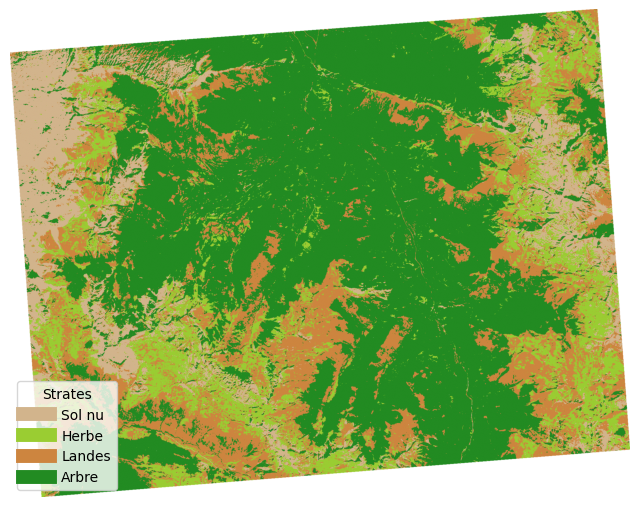

Carte des strates générée avec succès : /home/onyxia/work/results/carte_strates.tif


In [12]:
# ---Application du modèle sur l’image complète et génération de la carte de strates---


out_classif = "/home/onyxia/work/results/carte_strates.tif"

# Extraction des pixels + prédiction
X_img, _, t_img = cla.get_samples_from_roi(out_fused, out_fused)
Y_pred = best_model.predict(X_img)

# Reconstruction de la carte
ds = rw.open_image(ref_image)
nb_row, nb_col, _ = rw.get_image_dimension(ds)

ref_data = ds.GetRasterBand(1).ReadAsArray()  # pour le masque NoData/NaN

img = np.zeros((nb_row, nb_col, 1), dtype="uint8")
img[t_img[0], t_img[1], 0] = Y_pred

# Masque : zones sans donnée dans l’image de référence
img[np.isnan(ref_data), 0] = 0

# Écriture
rw.write_image(out_classif, img, data_set=ds, gdal_dtype=data_type_match["uint8"], nb_band=1)

# Fix NoData à 0
ds_out = gdal.Open(out_classif, gdal.GA_Update)
ds_out.GetRasterBand(1).SetNoDataValue(0)
ds_out = None
ds = None


# ---Affichage de la carte des strates dans le notebook---


# Lecture du raster classifié 
arr3d = rw.load_img_as_array(out_classif, verbose=False)
carte = arr3d[:, :, 0].astype(np.uint8)

# Liste de 5 couleurs (le premier 'white' pour la valeur 0)
colors_map = ['white',"tan", "yellowgreen", "peru", "forestgreen"]

# Création d’une palette de couleurs discrètes pour les classes de strates
my_cmap = ListedColormap(colors_map)

# Définition des bornes associées aux valeurs de classes (permet d’assurer une correspondance exacte entre valeurs et couleurs)
bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]

# Normalisation discrète des valeurs de classes à partir des bornes définies
norm = BoundaryNorm(bounds, my_cmap.N)

# Création de la figure pour l’affichage de la carte classifiée
plt.figure(figsize=(8, 8))

# Affichage de la carte des strates avec la colormap et la normalisation discrète
plt.imshow(img[:, :, 0], cmap=my_cmap, norm=norm)

# Construction manuelle de la légende à partir des couleurs et des noms des strates
for i, val in enumerate([1, 2, 3, 4], start=1):
    plt.plot([], [], color=colors_map[i], label=names[val], linewidth=10)

# Ajout de la légende, suppression des axes et affichage de la figure
plt.legend(title="Strates", loc="lower left")
plt.axis("off")
plt.show()

# Vérification de la création du raster de classification et affichage d’un message de confirmation
if os.path.exists(out_classif):
    print(f"Carte des strates générée avec succès : {out_classif}")
else:
    print("Erreur : la carte des strates n’a pas été générée.")



#### **4.3.5 Analyse des résultats**